In [1]:
using PyPlot
include("src/utils.jl")
include("src/netcdf.jl")

INFO: Loading help data...


read_ncdf (generic function with 1 method)

#Define Plot Functions

##Plot Distribution
This function plots the reconstructions for each algorithm at every error level for a given distribution. The plots are arranged in a grid with columns representing algorithms and rows representing error levels. Abbreviations are as follows...
* True: Actual distribution on a 15x15 grid
* TSVD: Truncated Singular Value Decomposition
* Tik0: Zeroth Order Tikhonov Regularization
* Tik1: First Order Tikhonov Regularization
* MF: Minimum Fisher Regularization
* ME: Maximum Entropy Regularization

__All plots are on the same color scale__

In [2]:
function plot_dists(device,dist_name)

    tsvd = read_ncdf("data/"*device*"_tsvd.cdf")
    energy = tsvd["energy"]
    pitch  = tsvd["pitch"]
    tsvd_f = tsvd[dist_name*"_f"]
    
    tik0 = read_ncdf("data/"*device*"_tik0.cdf")
    tik0_f = tik0[dist_name*"_f"]
    
    tik1 = read_ncdf("data/"*device*"_tik1.cdf")
    tik1_f = tik1[dist_name*"_f"]
    
    mf   = read_ncdf("data/"*device*"_min_fisher.cdf")
    mf_f = mf[dist_name*"_f"]
    
    me   = read_ncdf("data/"*device*"_maxent.cdf")
    me_f = me[dist_name*"_f"]
    
    dist = read_ncdf("data/test_distributions.cdf")
    energy_full = reshape(dist["E"][1,:],100)
    pitch_full  = reshape(dist["P"][:,1],100)
    d = bilinear(dist[dist_name],energy_full,pitch_full,energy,pitch)
    dmin,dmax=extrema(d)
    err_level = [0.05:0.05:1.0]
    fig, ax = plt.subplots(ncols=6,nrows=20,sharey=true,sharex=true)
    #plt.subplots_adjust(hspace=0.001,wspace=0.001)
    fig[:set_size_inches](9,30)
    ax[1,1][:set_title]("True")
    ax[1,2][:set_title]("TSVD")
    ax[1,3][:set_title]("Tik0")
    ax[1,4][:set_title]("Tik1")
    ax[1,5][:set_title]("MF")
    ax[1,6][:set_title]("ME")
    for i=1:20
        ax[i,1][:contourf](energy,pitch,d,30,vmin=dmin,vmax=dmax)
        ax[i,2][:contourf](energy,pitch,reshape(tsvd_f[:,i],15,15),30,vmin=dmin,vmax=dmax)
        ax[i,3][:contourf](energy,pitch,reshape(tik0_f[:,i],15,15),30,vmin=dmin,vmax=dmax)
        ax[i,4][:contourf](energy,pitch,reshape(tik1_f[:,i],15,15),30,vmin=dmin,vmax=dmax)
        ax[i,5][:contourf](energy,pitch,reshape(mf_f[:,i],15,15),30,vmin=dmin,vmax=dmax)
        ax[i,6][:contourf](energy,pitch,reshape(me_f[:,i],15,15),30,vmin=dmin,vmax=dmax)
        ax[i,1][:set_ylabel](@sprintf("%3.2f",err_level[i]))
        ax[i,1][:set_yticks]([])
        for j=1:6
            ax[i,j][:set_xticks]([])
        end
    end
    fig[:tight_layout](h_pad=0.1,w_pad=0.1)
end

plot_dists (generic function with 1 method)

##Mean Absolute Error
The function calculates the following at different error levels for a given distribution
$$MAE = \frac{1}{N} \sum_{i=1}^N |recon[i] - true[i]|$$

Abbreviations are the same as ```plot_dists```

In [3]:
function mean_abs_error(device,dist_name)

    tsvd = read_ncdf("data/"*device*"_tsvd.cdf")
    energy = tsvd["energy"]
    pitch  = tsvd["pitch"]
    coverage = reshape(sum(tsvd["A"],1) .>= eps(),15*15)
    tsvd_diff = tsvd[dist_name*"_diff"]
    tsvd_std  = std(tsvd_diff[coverage,:],1)
    tsvd_diff = mean(abs(tsvd_diff[coverage,:]),1)
    
    tik0 = read_ncdf("data/"*device*"_tik0.cdf")
    tik0_diff = tik0[dist_name*"_diff"]
    tik0_std  = std(tik0_diff[coverage,:],1)
    tik0_diff = mean(abs(tik0_diff[coverage,:]),1)
    
    tik1 = read_ncdf("data/"*device*"_tik1.cdf")
    tik1_diff = tik1[dist_name*"_diff"]
    tik1_std  = std(tik1_diff[coverage,:],1)
    tik1_diff = mean(abs(tik1_diff[coverage,:]),1)
    
    mf   = read_ncdf("data/"*device*"_min_fisher.cdf")
    mf_diff = mf[dist_name*"_diff"]
    mf_std  = std(mf_diff[coverage,:],1)
    mf_diff = mean(abs(mf_diff[coverage,:]),1)
    
    me   = read_ncdf("data/"*device*"_maxent.cdf")
    me_diff = me[dist_name*"_diff"]
    me_std  = std(me_diff[coverage,:],1)
    me_diff = mean(abs(me_diff[coverage,:]),1)
    
    err_level = [0.05:0.05:1.0]
    fig, ax = plt.subplots()
    fig[:set_size_inches](8,5)
    ax[:plot](err_level,tsvd_diff',label="TSVD")
    ax[:plot](err_level,tik0_diff',label="Tik0")
    ax[:plot](err_level,tik1_diff',label="Tik1")
    ax[:plot](err_level,mf_diff',label="MF")
    ax[:plot](err_level,me_diff',label="ME")
    ax[:legend](ncol=5,loc=3,fontsize=10)
    #ax[:set_xlim](0.1,1.0)
    ax[:set_ylim](1e8,1e10)
    ax[:set_yscale]("log")
    ax[:set_ylabel]("Mean Absolute Error")
    ax[:set_xlabel]("Error Level")
    ax[:set_title](dist_name*" Distribution Comparison")
    fig[:tight_layout]()
end

mean_abs_error (generic function with 1 method)

##Relative Density
This function calculates the density relative to the true distribution at different error levels.. The horizontal dashed line represents the relative density over the phase space region "seen" by the weight functions.

In [4]:
function relative_density(device,dist_name)

    tsvd = read_ncdf("data/"*device*"_tsvd.cdf")
    energy = tsvd["energy"]
    pitch  = tsvd["pitch"]
    coverage = reshape(sum(tsvd["A"],1) .>= eps(),15*15)
    tsvd_f = tsvd[dist_name*"_f"]
    tsvd_f = sum(tsvd_f,1)'
    
    tik0 = read_ncdf("data/"*device*"_tik0.cdf")
    tik0_f = tik0[dist_name*"_f"]
    tik0_f = sum(tik0_f,1)'
    
    tik1 = read_ncdf("data/"*device*"_tik1.cdf")
    tik1_f = tik1[dist_name*"_f"]
    tik1_f = sum(tik1_f,1)'
    
    mf   = read_ncdf("data/"*device*"_min_fisher.cdf")
    mf_f = mf[dist_name*"_f"]
    mf_f = sum(mf_f,1)'
    
    me   = read_ncdf("data/"*device*"_maxent.cdf")
    me_f = me[dist_name*"_f"]
    me_f = sum(me_f,1)'
    
    dist = read_ncdf("data/test_distributions.cdf")
    energy_full = reshape(dist["E"][1,:],100)
    pitch_full  = reshape(dist["P"][:,1],100)
    d = bilinear(dist[dist_name],energy_full,pitch_full,energy,pitch)
    
    dens_full = sum(d)
    dens_cov  = sum(d[reshape(coverage,15,15)])/dens_full
    
    err_level = [0.05:0.05:1.0]
    fig, ax = plt.subplots()
    fig[:set_size_inches](8,5)
    ax[:plot](err_level,tsvd_f./dens_full,label="TSVD")
    ax[:plot](err_level,tik0_f./dens_full,label="Tik0")
    ax[:plot](err_level,tik1_f./dens_full,label="Tik1")
    ax[:plot](err_level,mf_f./dens_full,label="MF")
    ax[:plot](err_level,me_f./dens_full,label="ME")
    ax[:plot](err_level,err_level.*0 + dens_cov,"k--")
    ax[:legend](ncol=5,loc=3,fontsize=10)
    #ax[:set_xlim](0.1,1.0)
    ymax = maximum([tsvd_f[3:end],tik0_f[3:end],tik1_f[3:end],mf_f[3:end],me_f[3:end]]./dens_full)
    ax[:set_ylim](0,max(1.0,1.1*ymax))
    ax[:set_ylabel]("Relative Density ")
    ax[:set_xlabel]("Error Level")
    ax[:set_title](dist_name*" Density Comparison")
    fig[:tight_layout]()
end

relative_density (generic function with 1 method)

#D3D Analysis
##Flat Distribution

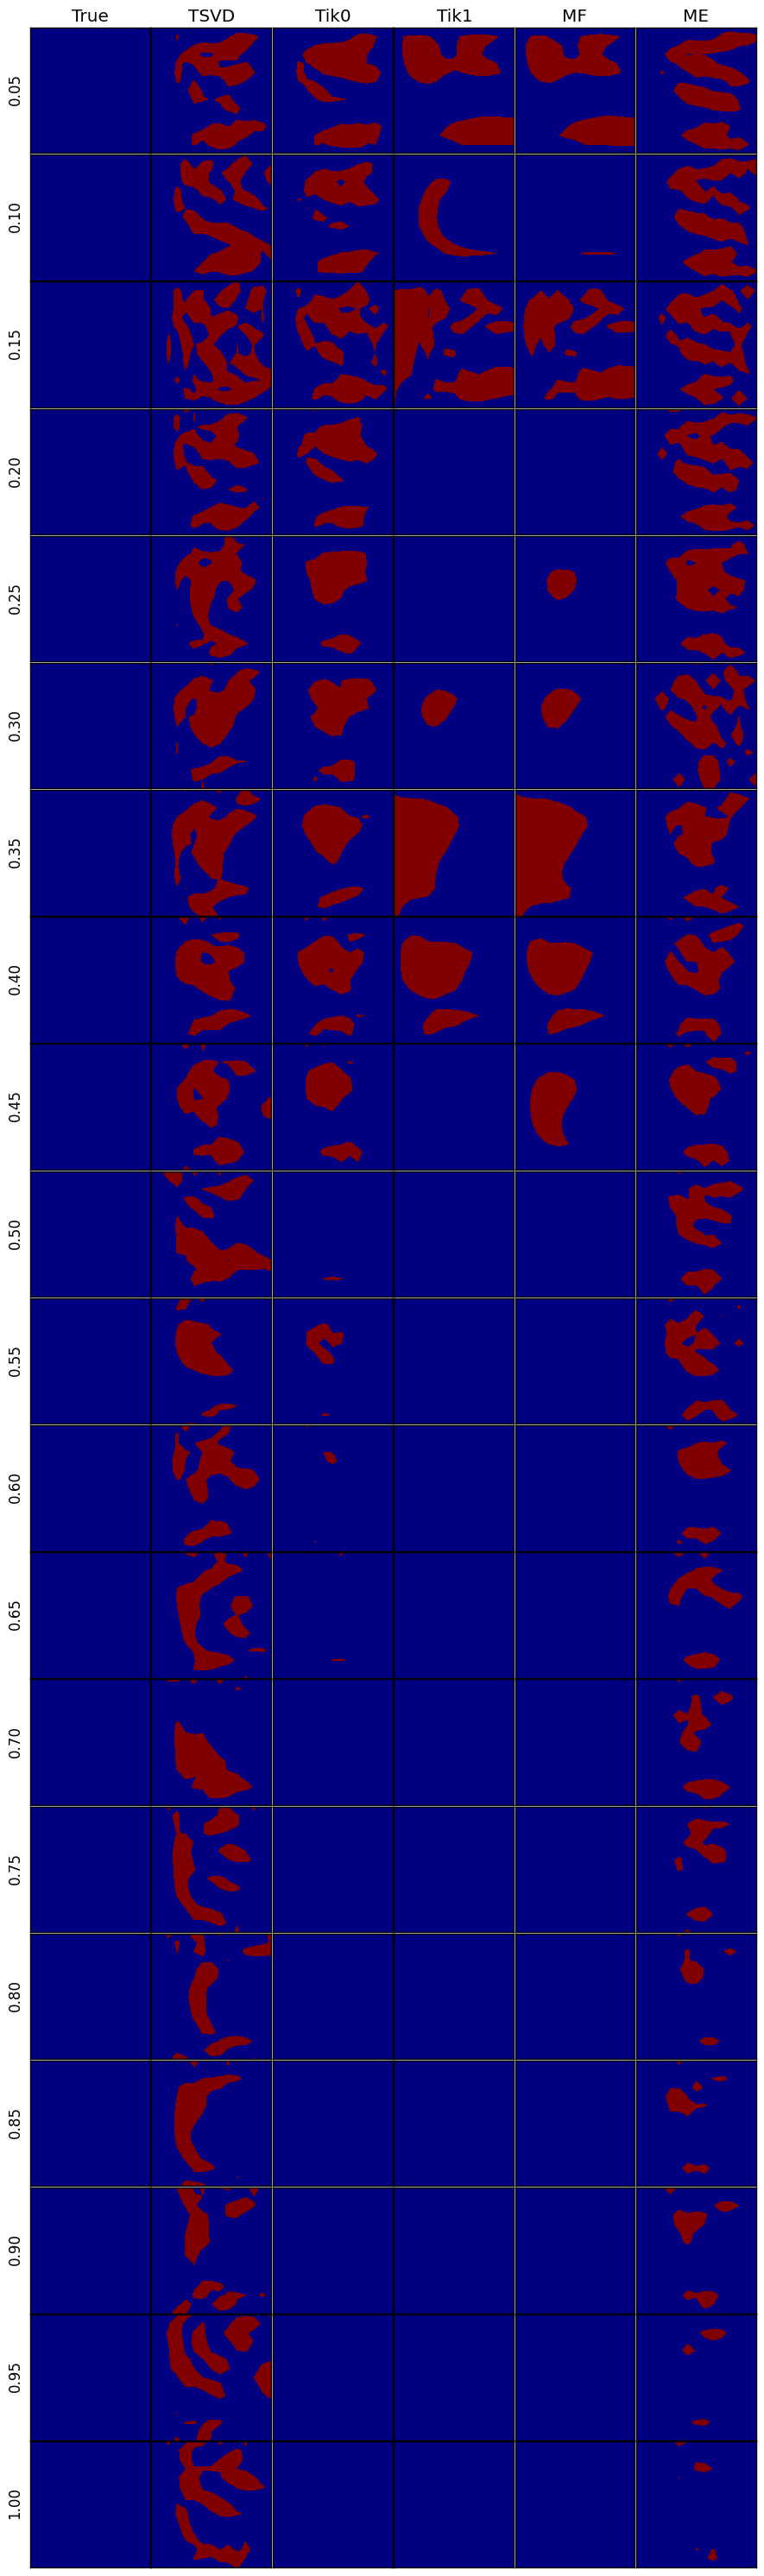

In [5]:
plot_dists("d3d","flat")

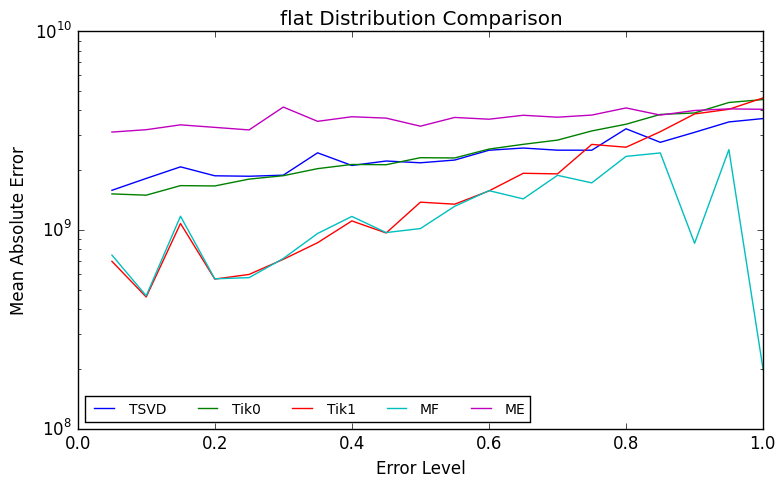

In [6]:
mean_abs_error("d3d","flat")

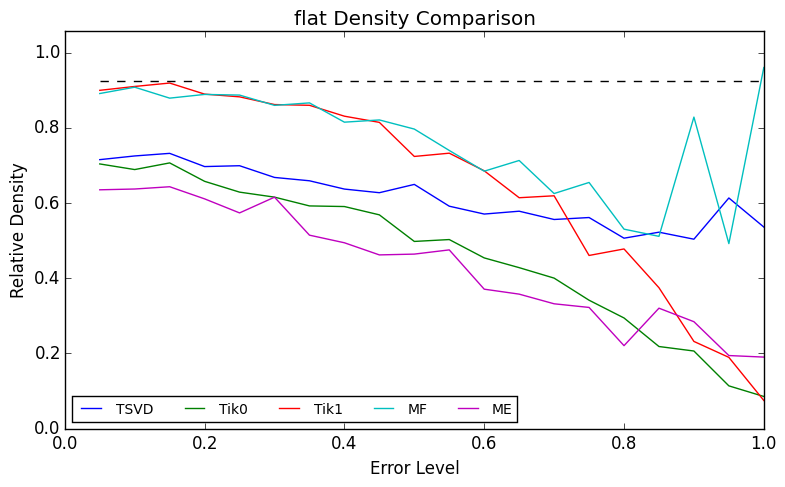

In [7]:
relative_density("d3d","flat")

##Blob Distribution

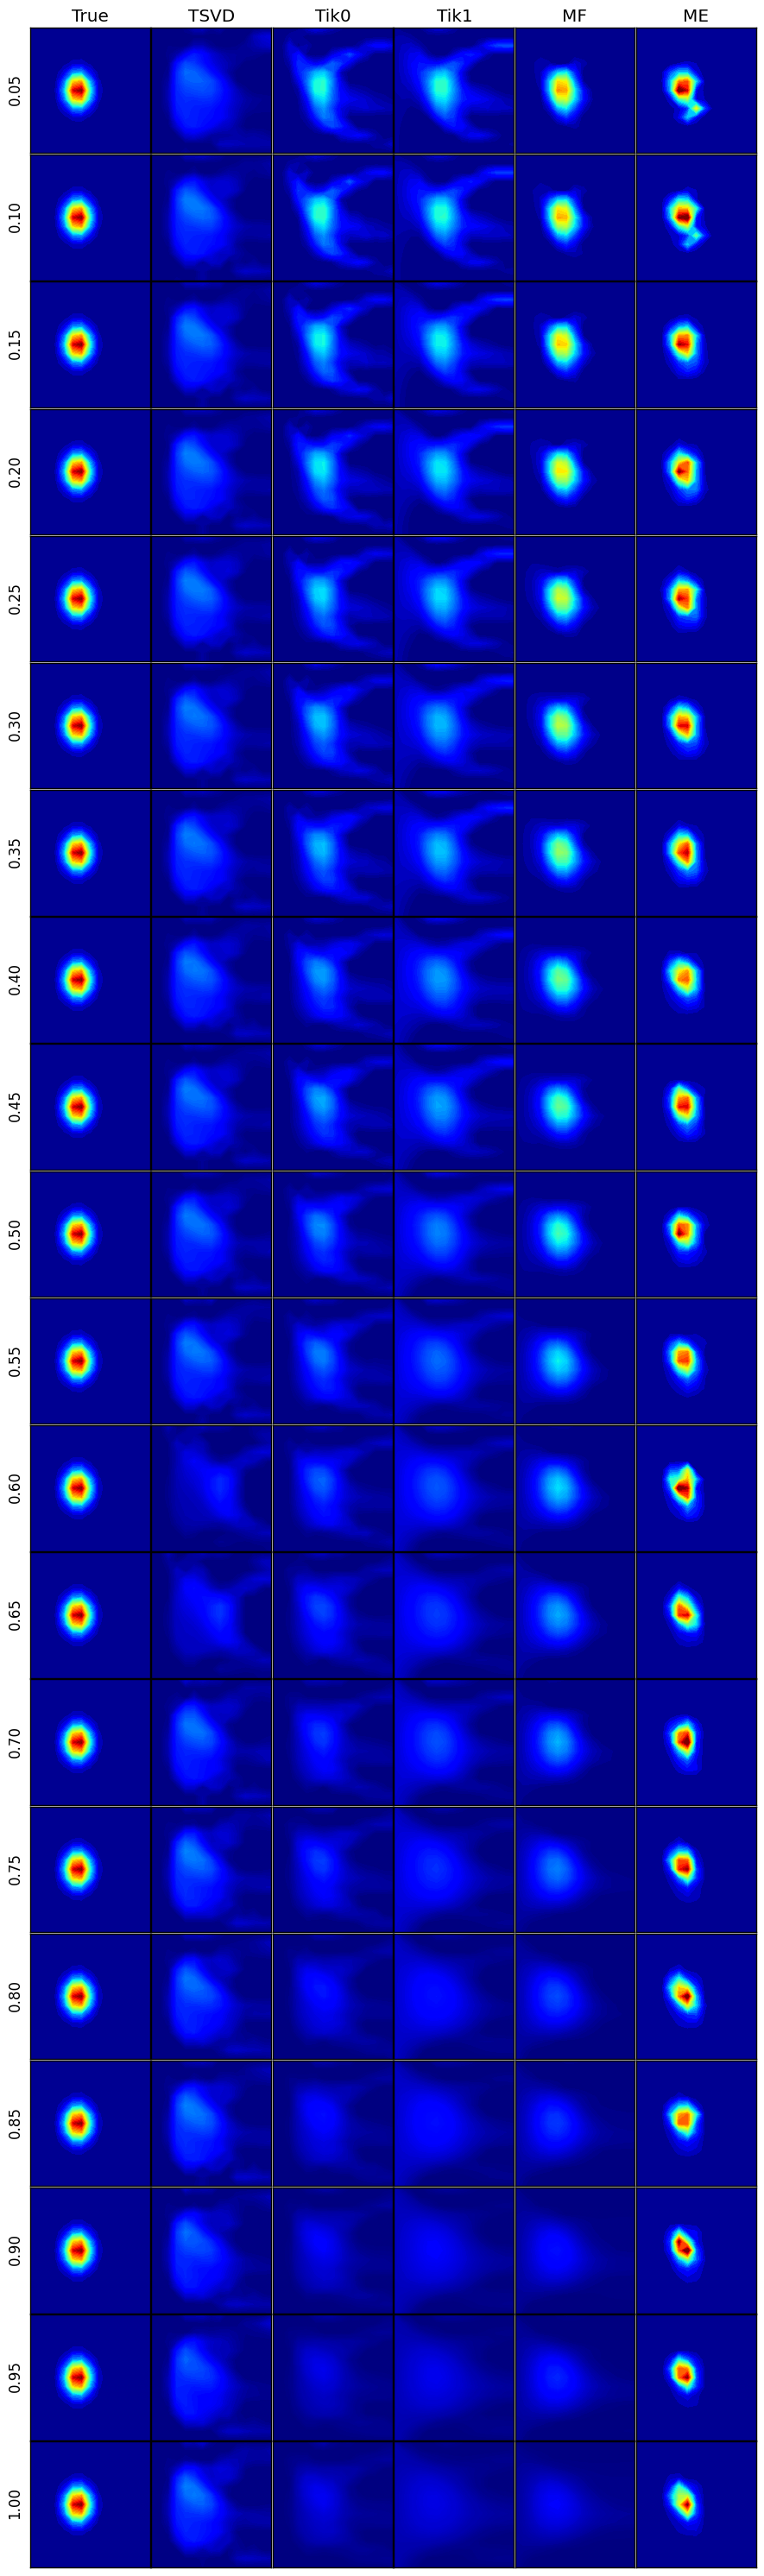

In [8]:
plot_dists("d3d","blob")

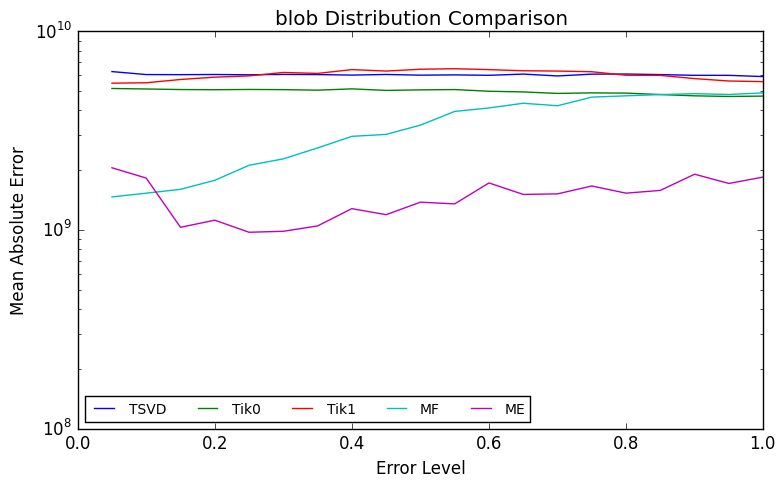

In [9]:
mean_abs_error("d3d","blob")

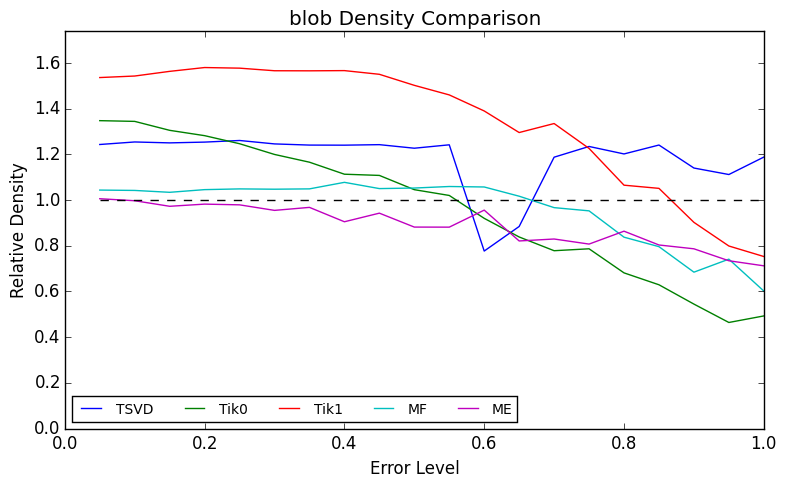

In [10]:
relative_density("d3d","blob")

##Blob6 Distribution

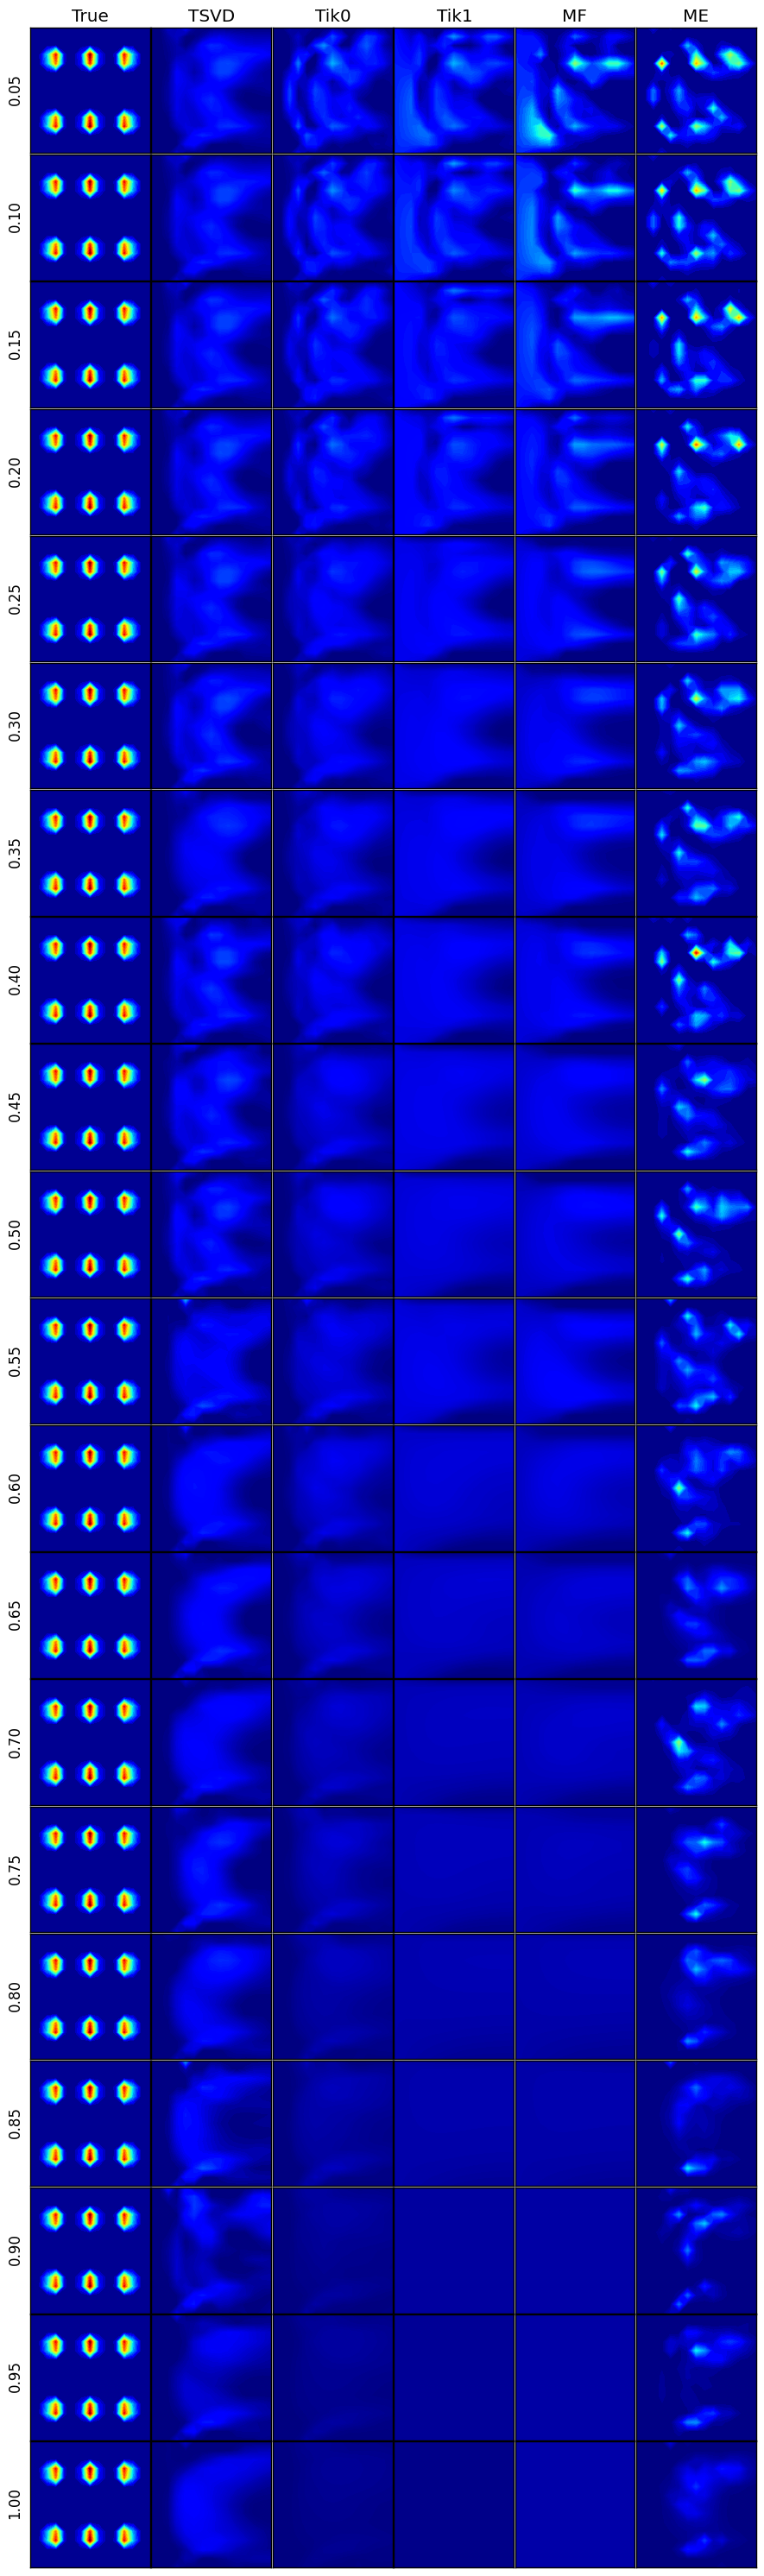

In [11]:
plot_dists("d3d","blob6")

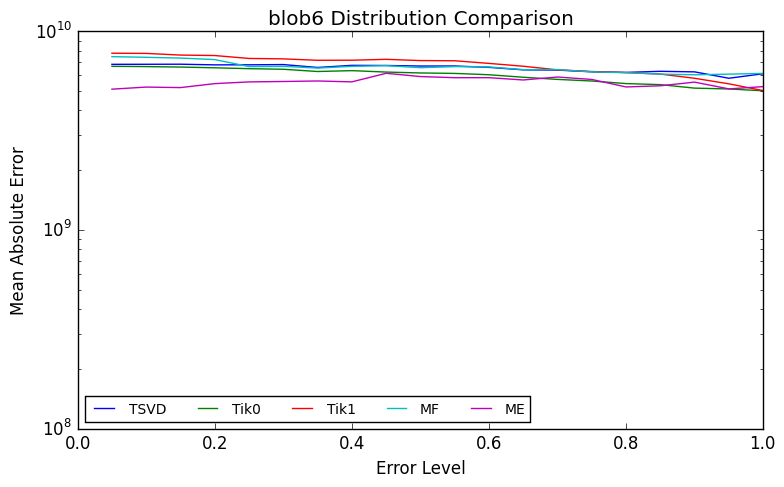

In [12]:
mean_abs_error("d3d","blob6")

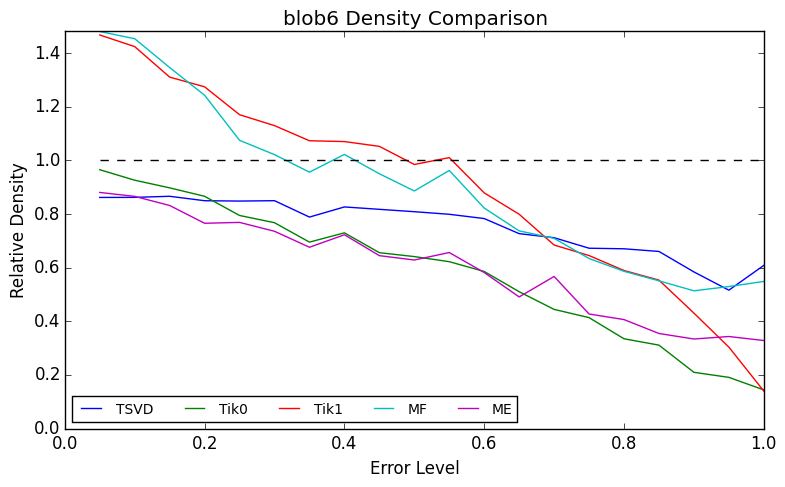

In [13]:
relative_density("d3d","blob6")

##Bi-maxwellian Distribution

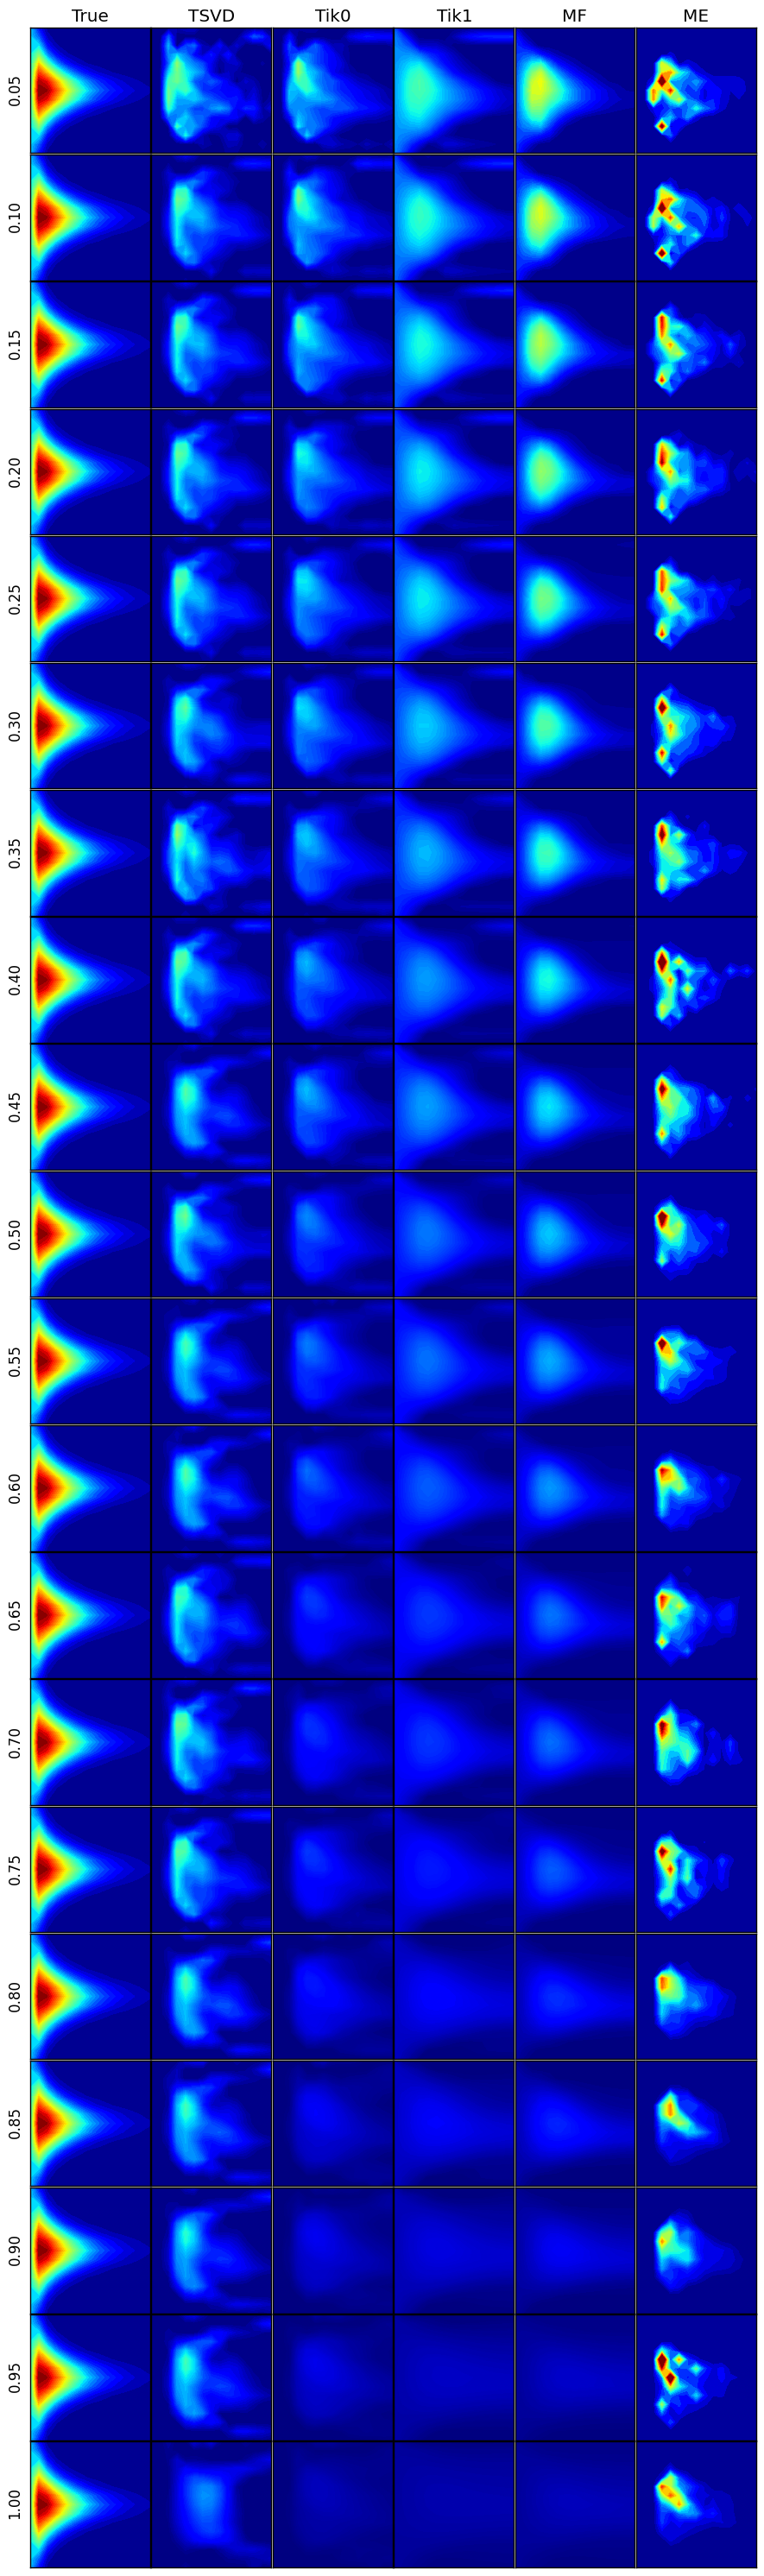

In [14]:
plot_dists("d3d","bimax")

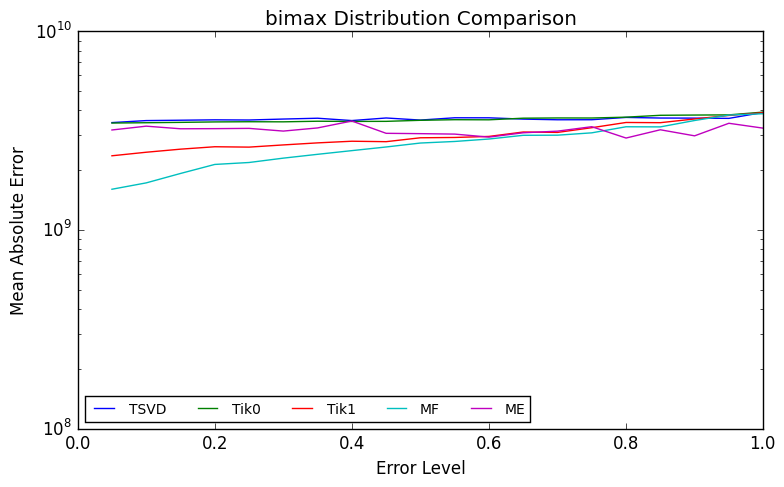

In [15]:
mean_abs_error("d3d","bimax")

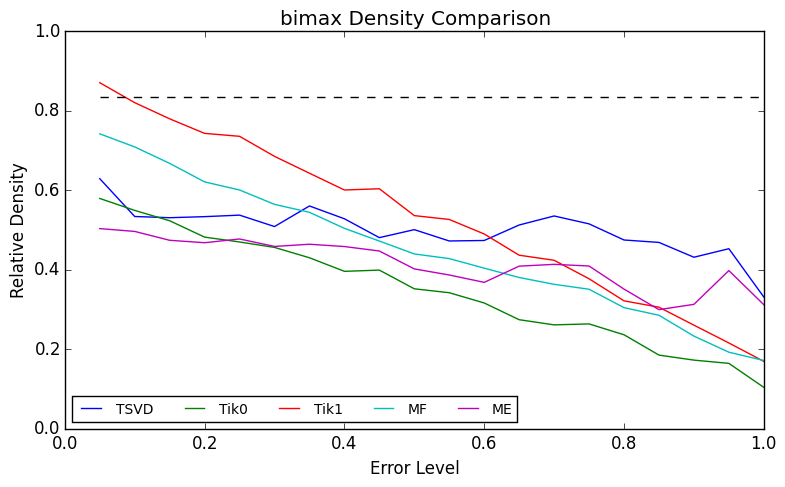

In [16]:
relative_density("d3d","bimax")

##TRANSP Distribution

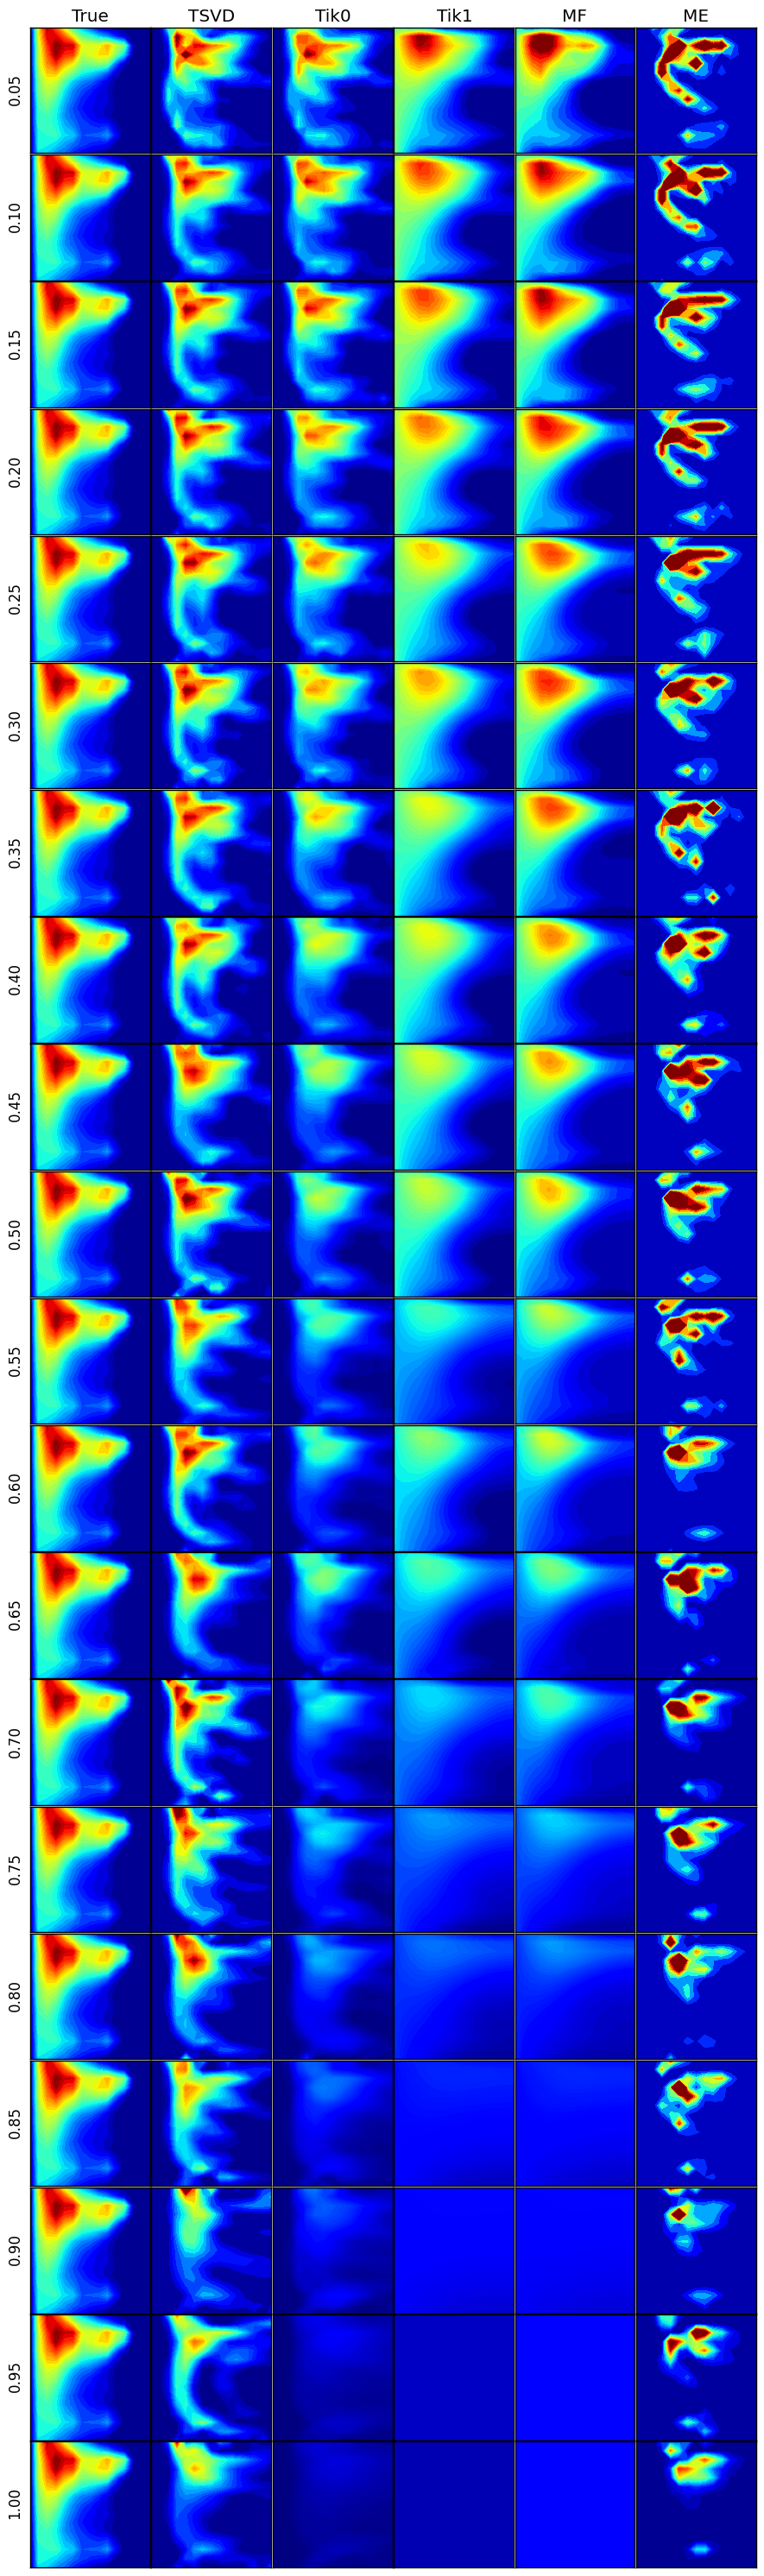

In [17]:
plot_dists("d3d","transp")

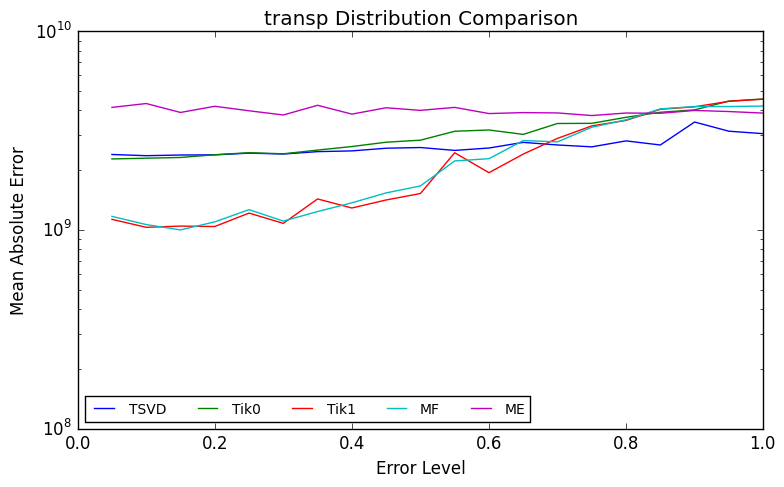

In [18]:
mean_abs_error("d3d","transp")

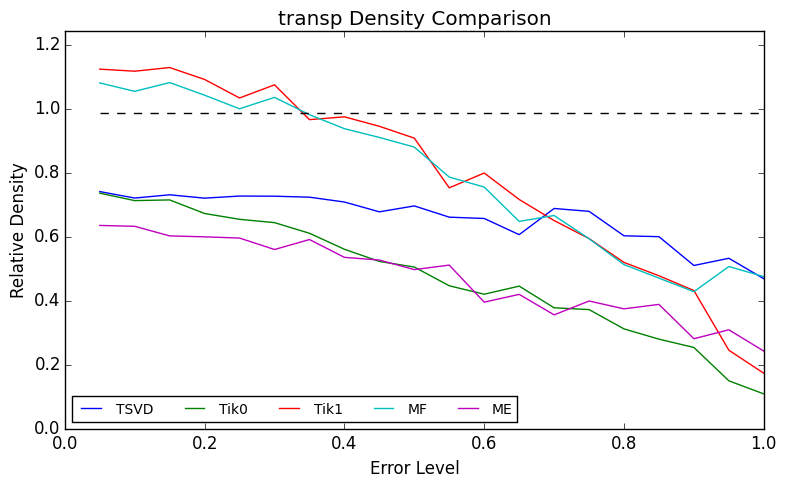

In [19]:
relative_density("d3d","transp")